In [1]:
import keras
from keras.models import load_model
from keras.preprocessing import image

from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import seaborn as sns
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from PIL import Image
import PIL
print(tf.config.list_physical_devices('GPU'))

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import SciServer.CasJobs as CasJobs # query with CasJobs, the primary database for the SDSS
import SciServer.SkyServer as SkyServer # show individual objects through SkyServer
import SciServer.SciDrive

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# # Helper functions for visualization:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5])

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [3]:
# Load the trained model
# model = models.load_model(f'../Models/{modelStr}.h5')
# modelName = f'pcc_resnet50_{modelNum}' # template is currently pcc_resnet50_X, where X is the iteration of the model

modelName = f'cluster_pcc_resnet50_7' # template is currently pcc_resnet50_X, where X is the iteration of the model
model = keras.models.load_model(f'../Models/{modelName}.h5')



IMG_WIDTH, IMG_HEIGHT = 200, 200
def make_prediction(img_path):
    # Load and preprocess the input image
    # img_path = '../Images/PCC-and-SpecSearch/sdss_ra=48.9999795273873_dec=41.2875102706543-label=0.png'
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Normalize pixel values (assuming your model was trained with normalized inputs)
    
    # Make predictions
    predictions = model.predict(img_array)
    
    # Postprocess predictions
    predicted_class = np.argmax(predictions)  # Assuming your model outputs class probabilities
    class_labels = ['0', '1']  # Define your class labels accordingly
    predicted_label = class_labels[predicted_class]
    
    # print('Predicted class:', predicted_label)
    return(predicted_label)

# trainImgs = os.path.join('..', 'Images', 'PCC-and-SpecSearch', '*.png')
# trainImgList = glob.glob(trainImgs)

trainObjs_filtered = pd.read_csv('../Sheets/trainObjects_filtered.csv')
trainImgList = trainObjs_filtered['files']


misses = 0
true_labels = [None]*len(trainImgList)
pred_labels = [None]*len(trainImgList)

for ind, imString in enumerate(trainImgList):
    imString = os.path.join('..', 'Images', 'PCC-and-SpecSearch', imString)
    
    ground_truth_label = imString[-5]
    pred_label = make_prediction(imString)


    true_labels[ind] = ground_truth_label
    pred_labels[ind] = pred_label
    
    if pred_label != ground_truth_label:
        misses += 1

print(f'{misses} misses on predicting training set')
print(f'{len(trainImgList)} images in training set')


16 misses on predicting training set
458 images in training set


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       230
           1       0.97      0.96      0.96       228

    accuracy                           0.97       458
   macro avg       0.97      0.97      0.97       458
weighted avg       0.97      0.97      0.97       458



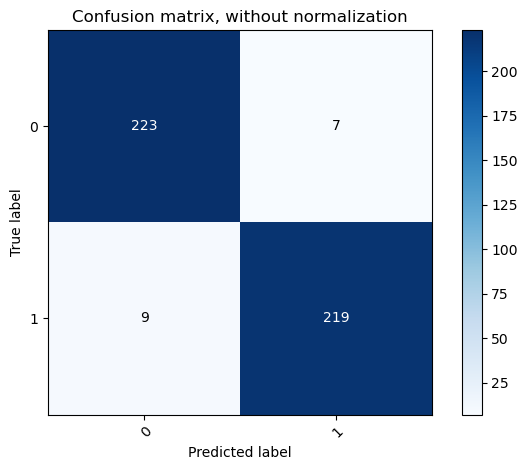

In [4]:
## NOTE This is the model on the training set
plot_confusion_matrix(true_labels, pred_labels)
print(classification_report(true_labels, pred_labels))

In [5]:
trainObjs_filtered['true_labels'] = true_labels
trainObjs_filtered['pred_labels'] = pred_labels
trainObjs_filtered['label_diffs'] = trainObjs_filtered['true_labels'].astype('int') - trainObjs_filtered['pred_labels'].astype('int')

# trainObjs_filtered['pred_labels'].value_counts()
# trainObjs_filtered['true_labels'].value_counts()
# trainObjs_filtered['labels'].value_counts()

In [6]:
trainObjs_filtered.head()

,Unnamed: 0,Unnamed: 1,ra,dec,labels,files,reds,true_labels,pred_labels,label_diffs
0,PCC_Bg,3848,49.8038,41.5811,0,sdss_ra=49.8038_dec=41.5811-label=0.png,2.1575,0,0,0
1,PCC_Bg,2340,49.6184,41.4546,0,sdss_ra=49.6184_dec=41.4546-label=0.png,1.7875,0,0,0
2,PCC_Bg,5416,50.0028,41.3384,0,sdss_ra=50.0028_dec=41.3384-label=0.png,3.4875,0,0,0
3,PCC_Bg,5239,49.9814,41.4202,0,sdss_ra=49.9814_dec=41.4202-label=0.png,1.5600,0,0,0
4,PCC_Bg,524,49.3342,41.3300,0,sdss_ra=49.3342_dec=41.33-label=0.png,8.2500,0,0,0


In [7]:
trainObjs_filtered['label_diffs'].value_counts()
trainObjs_filtered = trainObjs_filtered[['Unnamed: 0', 'Unnamed: 1', 'files', 'labels', 'true_labels', 'pred_labels', 'label_diffs', 'ra', 'dec']]
trainObjs_filtered.to_csv('../Sheets/trainObjsUpload.csv')
trainObjs_filtered

,Unnamed: 0,Unnamed: 1,files,labels,true_labels,pred_labels,label_diffs,ra,dec
0,PCC_Bg,3848,sdss_ra=49.8038_dec=41.5811-label=0.png,0,0,0,0,49.803800,41.581100
1,PCC_Bg,2340,sdss_ra=49.6184_dec=41.4546-label=0.png,0,0,0,0,49.618400,41.454600
2,PCC_Bg,5416,sdss_ra=50.0028_dec=41.3384-label=0.png,0,0,0,0,50.002800,41.338400
3,PCC_Bg,5239,sdss_ra=49.9814_dec=41.4202-label=0.png,0,0,0,0,49.981400,41.420200
4,PCC_Bg,524,sdss_ra=49.3342_dec=41.33-label=0.png,0,0,0,0,49.334200,41.330000
...,...,...,...,...,...,...,...,...,...
453,Spec_Mems,267,sdss_ra=50.622745654887_dec=41.0504450153301-l...,1,1,1,0,50.622746,41.050445
454,Spec_Mems,271,sdss_ra=50.6945934204297_dec=41.9412303787257-...,1,1,1,0,50.694593,41.941230
455,Spec_Mems,272,sdss_ra=49.7058490785794_dec=40.8275889370729-...,1,1,1,0,49.705849,40.827589
456,Spec_Mems,273,sdss_ra=49.112658441068_dec=41.1802159335769-l...,1,1,1,0,49.112658,41.180216


In [8]:
crossmatch = pd.read_csv(os.path.join('..', 'Sheets', 'trainObjects_filtered_CrossMatched.csv'), skiprows=1)
crossmatch.head()

,labels,true_labels,pred_labels,label_diffs,objID,ra,dec,r,r0,g_z0,u_g,g_z,g_r,g_i,r_i,r_z,distance
0,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
1,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
2,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
3,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
4,1,1,1,0,1237661059574334576,49.907725,41.472517,22.05002,21.68037,2.257058,-0.048845,2.587074,1.522949,2.158566,0.635616,1.064125,2.999543


In [9]:
## Uncomment for big pairplot:
pairDf = crossmatch[['ra', 'dec', 'r', 'u_g', 'g_z', 'g_r', 'true_labels', 'pred_labels', 'label_diffs']]

# p1 = sns.pairplot(pairDf, corner = False, hue = 'true_labels')
# p1.map_diag(sns.histplot)
# p1.map_upper(sns.kdeplot)
# p1.fig.suptitle('True labels')
# # p1.savefig(f'../Images/{modelName}-classifying-training-set.png')


In [10]:
# p2 = sns.pairplot(pairDf, corner = False, hue = 'pred_labels')
# p2.map_diag(sns.histplot)
# p2.map_upper(sns.kdeplot)
# p2.fig.suptitle('Predicted labels')
# # p1.savefig(f'../Images/{modelName}-classifying-training-set.png')


In [11]:
x_vars = pairDf[['u_g', 'g_z', 'g_r']]
y_vars = pairDf[['r']]

padding = 1
y_lim = (y_vars.min()[0] - padding , y_vars.max()[0] + padding)

Text(0.5, 0.98, 'Plot of true labels')

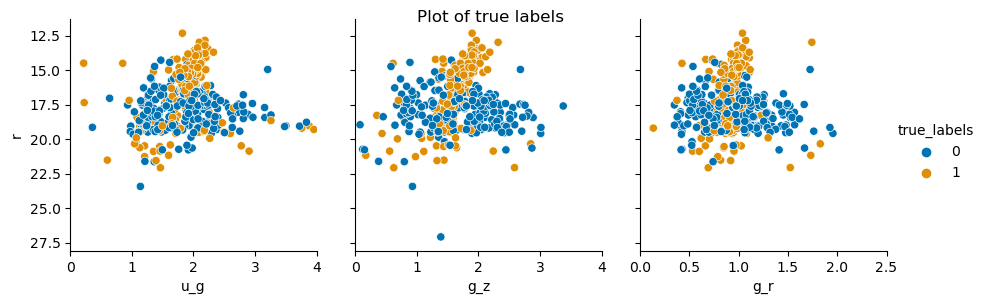

In [62]:
true_plot = sns.PairGrid(pairDf, hue="true_labels", palette = 'colorblind', x_vars=x_vars, y_vars=y_vars, height = 3)
# f.map_diag(sns.histplot, color=".3")
true_plot.map_offdiag(sns.scatterplot)
true_plot.add_legend()

## y limits
true_plot.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
true_plot.axes[0, 0].set_xlim((0, 4))
true_plot.axes[0, 1].set_xlim((0, 4))
true_plot.axes[0, 2].set_xlim((0, 2.5))
true_plot.fig.suptitle('Plot of true labels')

Text(0.5, 0.98, 'Plot of predicted labels')

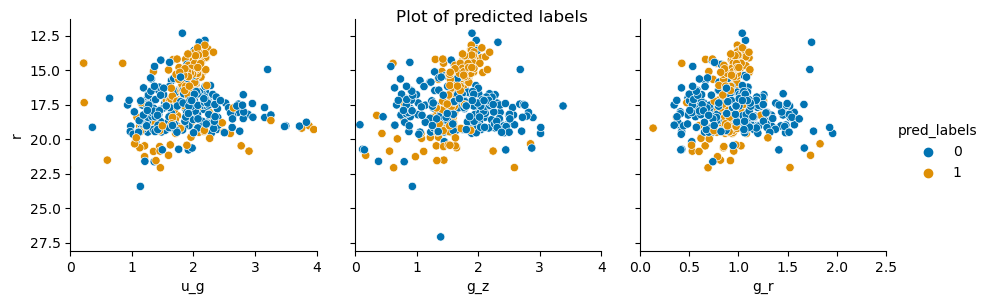

In [63]:
pred_plot = sns.PairGrid(pairDf, hue="pred_labels", palette = 'colorblind', x_vars=x_vars, y_vars=y_vars, height = 3)
# f.map_diag(sns.histplot, color=".3")
pred_plot.map_offdiag(sns.scatterplot)
pred_plot.add_legend()

## y limits
pred_plot.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
pred_plot.axes[0, 0].set_xlim((0, 4))
pred_plot.axes[0, 1].set_xlim((0, 4))
pred_plot.axes[0, 2].set_xlim((0, 2.5))
pred_plot.fig.suptitle('Plot of predicted labels')


Text(0.5, 0.98, 'Differences between labels')

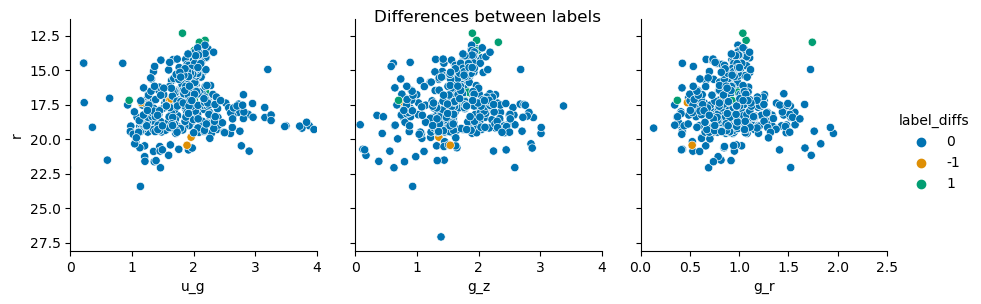

In [66]:


diff_plot = sns.PairGrid(pairDf, hue="label_diffs", palette = 'colorblind', x_vars=x_vars, y_vars=y_vars, height = 3, hue_order = [0, -1, 1] )
# f.map_diag(sns.histplot, color=".3")
diff_plot.map_offdiag(sns.scatterplot)
diff_plot.add_legend()

## y limits
diff_plot.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
diff_plot.axes[0, 0].set_xlim((0, 4))
diff_plot.axes[0, 1].set_xlim((0, 4))
diff_plot.axes[0, 2].set_xlim((0, 2.5))
diff_plot.fig.suptitle('Differences between labels')
# f.axes[0, 1].set_xlim(modMagr_lim[::-1])
# f.axes[0, 2].set_xlim(petroRad_r_lim)
# f.savefig(f'../Images/{modelName}-Rmag-vs-color.png')
# diff_plot.map(sns.scatterplot, s=1, alpha = 1)
# diff_plot

In [15]:
def dra_dec(ra,dec,ra0,dec0) :
	''' calculate angular separation in RA and Dec,
    	given input coords and reference coords,
    	all in radians
	'''
	dra = (np.sin(ra - ra0) * np.cos(dec))
	ddec = -np.cos(ra - ra0) * np.cos(dec) * np.sin(dec0) + np.sin(dec) * np.cos(dec0)
	return np.array([dra, ddec]) # in radians

ra0, dec0 = 49.9506671, 41.5116961 # NGC 1275, from NED

clustCent_R = []
for ra, dec in zip(pairDf['ra'], pairDf['dec']):
    dra, ddec = dra_dec(np.radians(ra), np.radians(dec), np.radians(ra0), np.radians(dec0))
    R_clust = np.sqrt(dra**2+ddec**2) * 75e3
    clustCent_R.append(R_clust)
pairDf['ClusterCentRad'] = clustCent_R

C:\Users\Jason\AppData\Local\Temp\ipykernel_9848\3723318498.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairDf['ClusterCentRad'] = clustCent_R


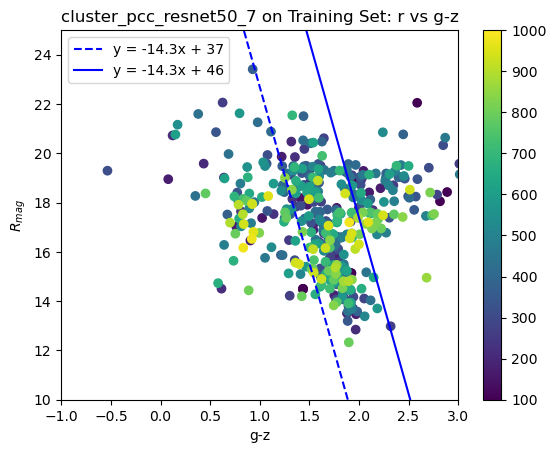

In [16]:
gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?

x1 = pairDf['u_g']
x2 = pairDf['g_z']

x3 = pairDf['r']

plt.figure()
xx = np.linspace(-1, 3) 

plt.scatter(x2, x3, c = pairDf['ClusterCentRad'], vmin = 100, vmax = 1000)
plt.plot(xx, xx*gz_slope + gz_intercept1, 'b--', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
plt.plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
plt.ylim([10, 25])
# # plt.xlim(gz_lim)
plt.xlim((-1, 3))
# plt.axvline(x=1.90, color = 'r')
# plt.axvline(x=1.85, color = 'r', label = 'x = 1.85')
# plt.axvline(x=1.30, color = 'r', label = 'x = 1.30')
# plt.axvline(x=1.575, color = 'r', label = 'x = 1.575')
plt.colorbar()
plt.ylabel('$R_{mag}$')
plt.xlabel('g-z')
plt.title(f'{modelName} on Training Set: r vs g-z')
plt.legend()
plt.show()

In [18]:
blueCloud = pairDf.loc[ (pairDf['r'] > -14.3*pairDf['g_z'] + 46)]
redSequence = pairDf.loc[ (pairDf['r'] > -14.3*pairDf['g_z'] + 37) & (pairDf['r'] < -14.3*pairDf['g_z'] + 46)]
redShoulder = pairDf.loc[ (pairDf['r'] < -14.3*pairDf['g_z'] + 37)]

aug_labels_BlueCloud = ['a' + str(x) for x in blueCloud['true_labels']]
aug_labels_RedSeq = ['b' + str(x) for x in redSequence['true_labels']]
aug_labels_RedShould = ['c' + str(x) for x in redShoulder['true_labels']]

# blueCloud['aug_labels'] = aug_labels_BlueCloud
# redSequence['aug_labels'] = aug_labels_RedSeq
# redShoulder['aug_labels'] = aug_labels_RedShould
pairDf.loc[blueCloud.index, 'aug_labels'] = aug_labels_BlueCloud
pairDf.loc[redSequence.index, 'aug_labels'] = aug_labels_RedSeq
pairDf.loc[redShoulder.index, 'aug_labels'] = aug_labels_RedShould

C:\Users\Jason\AppData\Local\Temp\ipykernel_9848\2789169774.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairDf.loc[blueCloud.index, 'aug_labels'] = aug_labels_BlueCloud


In [19]:
pairDf['true_labels'].value_counts()
# blueCloud['labels'].value_counts()

0    218
1    215
Name: true_labels, dtype: int64

In [20]:
colorRegions = pd.concat([blueCloud, redSequence, redShoulder], keys = ['BlueCloud', 'RedSequence', 'RedShoulder'])
colorRegions

ra        dec         r       u_g       g_z       g_r  \
BlueCloud   4    49.907725  41.472517  22.05002 -0.048845  2.587074  1.522949   
            7    49.983366  41.455261  18.84386  1.555840  1.950048  1.016344   
            9    50.029920  41.552969  18.42844  3.159212  2.888931  1.524950   
            10   49.988331  41.445875  18.05160  2.727100  2.817200  1.565123   
            12   49.981414  41.420159  18.69531  2.256126  2.309149  1.302322   
...                    ...        ...       ...       ...       ...       ...   
RedShoulder 419  49.002174  41.408047  15.50514  1.792715  1.397194  1.081118   
            427  50.923527  41.522216  18.26587  1.417189  1.086142  0.697098   
            429  50.184406  40.800759  16.81091  1.468370  0.935785  0.586376   
            430  48.999980  41.287510  16.52428  1.310324  0.920393  0.572069   
            431  49.167526  41.982382  16.16910  1.367605  0.834207  0.534445   

                 true_labels  pred_labels  label_diffs  ClusterCentRad  
BlueCloud   4              1            1            0       66.354771  
            7              0            0            0       80.532793  
            9              0            0            0       94.603199  
            10             0            0            0       93.743552  
            12             0            0            0      123.559025  
...                      ...          ...          ...             ...  
RedShoulder 419            0            0            0      940.270451  
            427            0            0            0      953.591651  
            429            0            0            0      958.675980  
            430            0            0            0      978.485916  
            431            0            0            0      982.101080  

[433 rows x 10 columns]

,0,1
BlueCloud,82,6
RedSequence,66,181
RedShoulder,70,28


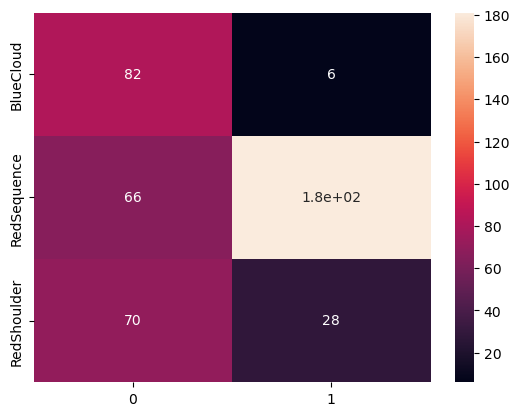

In [21]:
Cols = ['0', '1']
Index = ['BlueCloud', 'RedSequence', 'RedShoulder']


x = np.array([colorRegions['true_labels']['BlueCloud'].value_counts(),
              colorRegions['true_labels']['RedSequence'].value_counts()[::-1], # reorder to 0, 1
              colorRegions['true_labels']['RedShoulder'].value_counts()]
            )

df = pd.DataFrame(x, index=Index, columns=Cols)

sns.heatmap(df, annot=True)
df.style.background_gradient(cmap='Blues')
## This isn't quite correct - we want to see the false positives and negatives too

In [22]:
# colorRegions['labels']['BlueCloud'].value_counts()
# colorRegions['labels']['RedSequence'].value_counts()[::-1]
# colorRegions['labels']['RedShoulder'].value_counts()

In [23]:
def labeler(num):
    if (num > 0.01 and num < 0.033):
        return('1') # members
    else:
        return('0') # background
        

def get_images(df_in, dirName): 
        
    # df_in = df_in.drop_duplicates(subset = 'objID')
    # df_in['labels'] = pd.to_numeric(df_in['labels'], downcast='integer')
    
    img_width, img_height = 200, 200
    SkyServer_DataRelease = 'DR16'
    # dirName = 'PCC-and-SpecSearch'
    
    outDir = os.path.join('..', 'Images', dirName)
    
    fileList = list()

    ## create directory if doesn't currently exist 
    if not os.path.exists(outDir):
       os.makedirs(outDir)

    # if len(glob.glob(os.path.join(outDir, '*.png'))) == df_in.shape[0]:
    #     print('Skipping Populate')
    # else:
        # for id, r, d in zip(searchDf['objID'], df_in['ra'], df_in['dec']):
    
    for r, d, l in zip(df_in['ra'], df_in['dec'], df_in['labels']):
        img_array = SkyServer.getJpegImgCutout(ra = r, 
                                               dec = d, 
                                               width = img_width, 
                                               height = img_height, 
                                               scale = 0.1, 
                                               dataRelease = SkyServer_DataRelease)
        
        # print(f'{id}-label={labeler(z)}')
        # outPicTemplate = f'{id}-label={labeler(z)}.png'
        
        outPicTemplate = f'sdss_ra={r}_dec={d}-label={l}.png'
        
        img0 = PIL.Image.fromarray(img_array, 'RGB')
        img0.save(f'{outDir}/{outPicTemplate}')
        fileList.append(f'{outPicTemplate}')

    # print(f'Finished populate with {len(fileList)} images')

In [24]:
searchDf = pd.read_csv('../Sheets/testSearch_SQL4_9_2024 7_16_13 AM.csv', skiprows = 1)

In [25]:
label_map = map(labeler, searchDf['z'])
searchDf['labels'] = list(label_map)
searchDf['labels'] = searchDf['labels'].astype(str)
searchDf['labels'].value_counts()


0    393
1    259
Name: labels, dtype: int64

In [26]:
searchDf.drop_duplicates(subset = 'objID')
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
common_objs = intersection(searchDf['objID'], train_crossMatch['objID'])
cleanSearch = searchDf[~searchDf.objID.isin(common_objs)] 
cleanSearch.shape[0] == searchDf.shape[0] - len(common_objs)
searchDf.shape[0] - len(common_objs)
cleanSearch

NameError: name 'train_crossMatch' is not defined

In [27]:
# get_images(cleanSearch, 'TestImgsCleaned_4-9-24')

NameError: name 'cleanSearch' is not defined

In [28]:
testImgs = os.path.join('..', 'Images', 'TestImgsCleaned_4-9-24', '*.png')

y_true = [x[-5] for x in glob.glob(testImgs)] 
y_pred = [None]*len(y_true)
# len(y_pred) == len(y_true)

counter = 0
for ind, x in enumerate(glob.glob(testImgs)):
    pred = make_prediction(x)
    y_pred[ind] = pred
    if pred != x[-5]:
        counter += 1
        
# print(f'{counter} misses on test set')
# print(f'{len(glob.glob(testImgs))} images in test set')

In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       244
           1       0.84      0.85      0.84        86

    accuracy                           0.92       330
   macro avg       0.89      0.90      0.89       330
weighted avg       0.92      0.92      0.92       330



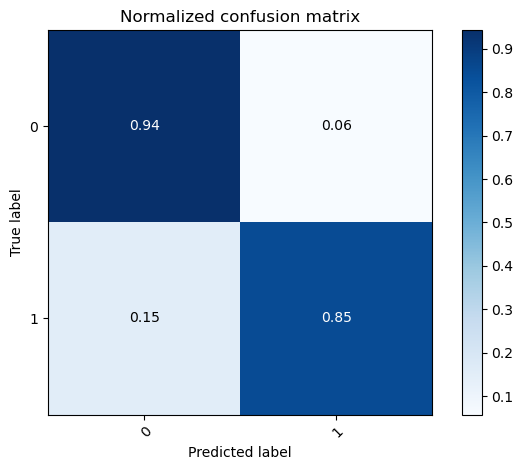

In [30]:
plot_confusion_matrix(y_true, y_pred, normalize=True)

In [ ]:
cleanSearch['labels'].value_counts()